# Overall Project:
### Based off of https://medium.com/@mjbhobe/mnist-digits-classification-with-keras-ed6c2374bd0e
* import & set global variables
* define load function
* define display data function
* load data
* display 50 samples
* import keras
* define construct keras model
* construct keras model
* train model (split load between CPU and GPU) (is timed)
* display loss & acuracy graphs
* reverse one-hot and show 50 predictions compared with the true values
* Saving & Loading the trained weights and model
* Input image(can be any size)
* Frontend
* Example graphs for different Values of alpha(Adam)
* Generated images can have random line thickness
* image generation for filled shape case
* cropped image as background
* Edge detection
* Fit shape to image size
* list Wrong predictions for finding corelations
* consecutive training on separate datasets
### TO-DO:
* generate image with resize blur
* Autoencoder with PCA(principle component analysis(CodeParade))

* Example graphs for different sized convolution kernel sizes(ex 3x3->85%, 9x9->93%,6x6->94%)(pool layers too?)
* Example graphs for different count of input data
* Example graphs for different epoch sizes
* Example graphs for resized data to make it more blurry
* Example graphs for randomised thickness of lines
* Example graphs for filled, unfilled and mixt shapes

* Slliding window for input image
* Visualising intermediate layer output of CNN
* Visualization of the Feature Maps Extracted
### Tentative:
* Remove most or all hardcoding: Image height width shape num classes class names
* Load data in batches
* Maybe use image segmentation but most probably does not utilise trained network
* Check output on optical illusions(triangle made of 3 4/5 circles)

In [95]:
#import warnings
#warnings.filterwarnings("ignore")
import logging
logging.getLogger('tensorflow').disabled = True

import os, random, cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.utils import np_utils

float_formatter = lambda x: '%.4f' % x
np.set_printoptions(formatter={'float_kind':float_formatter})
np.set_printoptions(threshold=np.inf, suppress=True, precision=4)

plt.style.use("seaborn-colorblind")
plt.rcParams["figure.figsize"] = (8, 6)
sns.set_style("darkgrid")
#sns.set_context("talk")
sns.set_context(context='notebook', font_scale=1.25)
sns.set_style({"font.sans-serif": ["Verdana", "Arial", "Calibri", "DejaVu Sans"]})

# NOTE: It is important that you set a seed value to get same results in every run.
# Any number is Ok.
seed = 817#123
random.seed(seed)
np.random.seed(seed)

#class_names = ['Ellipse','4lateral','3angle']
class_names = ['0','4','3']
num_channels, KERNEL_SIZE, alpha = 1, (9,9), 0.0003
IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_SHAPE, num_classes = 40, 40, (40,40,num_channels), len(class_names)
# training parameters
NUM_EPOCHS, BATCH_SIZE = 15, 128
# for loading & saving model state
KR_MODEL_NAME = 'keras_shapes.h5'

## Loading & Pre-processing the Images
We will load the images from the `keras.datasets.mnist` package, using the `load_data()` function. Keras ships with several datasets, like MNIST, Fashion, CIFAR-10 etc., which we can leverage for learning ML techniques.

The following pre-processing steps will be applied:
* The image data (X's) will be converted to floats & scaled to values between 0.0 & 1.0
* The labels (y's) will be one-hot encoded to width of 10 (as we have 10 output classes corresponding to digits 0-9)
* The training set (`X_train, y_train`) will be shuffled & split into training & cross-validation sets using an 80:20 split - we have 60,000 training examples, which will be split into two sets of 48,000 and 12,000 images &amp; labels. 
* The images & label arrays will be appropriately reshaped - `images -> (num_samples, num_features)`, `labels -> (num_samples, num_classes)`
* We will also keep a copy of the test images & labels (i.e. of `X_test & y_test`) _before_ any preprocessing is applied. This is to help with data visualization of the _'original dataset'_.

In [96]:
def edge_detection(frame):
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

    lower_red = np.array([30,150,50])
    upper_red = np.array([255,255,180])

    mask = cv2.inRange(hsv, lower_red, upper_red)
    res = cv2.bitwise_and(frame,frame, mask= mask)

    return cv2.Canny(frame,70,120)

In [97]:
def load_and_preprocess_data(debug=False, edgeDetect=False, folder='Fill2NoBg'):
    from keras.utils import to_categorical
    
    # loading data
    PATH = os.getcwd()
    # Define data path
    data_path = PATH + '/../ShapeData/' + folder
    data_dir_list = os.listdir(data_path)

    img_data_list=[]

    for dataset in data_dir_list:
        img_list=os.listdir(data_path+'/'+ dataset)
        print ('Loaded the images of dataset-'+'{}\n'.format(dataset))
        for img in img_list:
            if edgeDetect:
                input_img=cv2.imread(data_path + '/'+ dataset + '/'+ img,1)
                img_data_list.append(edge_detection(input_img))
            else:
                input_img=cv2.imread(data_path + '/'+ dataset + '/'+ img,0)#1=RGB,0=Grey,-1=unchanged
                img_data_list.append(input_img)
#            input_img_resize=cv2.resize(input_img,(IMAGE_HEIGHT,IMAGE_WIDTH))
#            img_data_list.append(input_img_resize)
#             img_data_list.append(edge_detection(input_img))
    
    X_train = np.array(img_data_list)
    num_data = X_train.shape[0]
    
    # Assigning Labels
    y_train = np.ones((num_data,),dtype='int64')
    for i in range(0,num_classes):
        y_train[int(np.floor((i)*num_data/num_classes)):int(np.floor((i+1)*num_data/num_classes))]=i
    
    if debug:
        print('Before preprocessing:')
        print(' - X_train.shape = {}, y_train.shape = {}'.format(X_train.shape, y_train.shape))

    #shuffle data
    indexes = np.random.permutation(X_train.shape[0])
    X_train, y_train = X_train[indexes], y_train[indexes]
    
    #split data into 3 parts & keep copy of test images and labels
    num_train=int(np.floor(num_data*0.8))
    num_cross=int(np.floor(num_train*0.2))
    
    X_val, y_val = X_train[num_train:num_train+num_cross], y_train[num_train:num_train+num_cross]
    X_test, y_test = X_train[num_train+num_cross:], y_train[num_train+num_cross:]
    test_images, test_labels = X_test.copy(), y_test.copy()
    X_train, y_train = X_train[:num_train], y_train[:num_train]
    
    #scale images and one-hot encode labels(from 0 to [1,0,0] ,1 to [0,1,0] etc)
    X_train = X_train.astype('float32') / 255.0
    X_val = X_val.astype('float32') / 255.0
    X_test = X_test.astype('float32') / 255.0
    y_train = to_categorical(y_train, num_classes) 
    y_val = to_categorical(y_val, num_classes)
    y_test = to_categorical(y_test, num_classes)
    
    #Reshaping
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2], num_channels))
    X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], X_val.shape[2], num_channels))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2], num_channels))
    
    if debug:
        print('After preprocessing: ')
        print(' - X_train.shape = {}, y_train.shape = {}'.format(X_train.shape, y_train.shape))
        print(' - X_val.shape = {}, y_val.shape = {}'.format(X_val.shape, y_val.shape))
        print(' - X_test.shape = {}, y_test.shape = {}'.format(X_test.shape, y_test.shape))
        print(' - test_images.shape = {}, test_labels.shape = {}'.format(
            test_images.shape, test_labels.shape))  
    
    return (X_train, y_train), (X_val, y_val), (X_test, y_test), (test_images, test_labels)

In [98]:
def display_sample(sample_images, sample_labels, sample_predictions=None,
                   num_rows=5, num_cols=10, plot_title=None, fig_size=None):
    """ 
    display a random selection of images & corresponding labels, optionally with predictions 
    The display is laid out in a grid of num_rows x num_col cells.
    If sample_predictions are provided, then each cell's title displays the prediction (if it 
    matches actual value) else it displays actual value/prediction. 
    """
    assert sample_images.shape[0] == num_rows * num_cols
    
    with sns.axes_style("whitegrid"):
        sns.set_context("notebook", font_scale=1.1)
        sns.set_style({"font.sans-serif": ["Verdana", "Arial", "Calibri", "DejaVu Sans"]})

        f, ax = plt.subplots(num_rows,num_cols,figsize=((14, 9) if fig_size is None else fig_size),
            gridspec_kw={"wspace": 0.02, "hspace": 0.30}, squeeze=True)

        for r in range(num_rows):
            for c in range(num_cols):
                image_index = r * num_cols + c
                ax[r, c].axis("off")
                # show selected image
                ax[r, c].imshow(sample_images[image_index] 
                                ,cmap="gray" #cmap grey so the image is black and white, not 2 random colours
                                ,vmin=0,vmax=255 #vmin and vmax is needed otherwise the image will be two tone
                                )

                if sample_predictions is None:
                    # show the actual labels in the cell title
                    title = ax[r, c].set_title(class_names[sample_labels[image_index]])
                else:
                    # else check if prediction matches actual value
                    true_label = class_names[sample_labels[image_index]]
                    pred_label = class_names[sample_predictions[image_index]]
                    prediction_matches_true = \
                        (sample_labels[image_index] == sample_predictions[image_index])
                    if prediction_matches_true:
                        # if actual == prediction, cell title is prediction shown in green font
                        title = true_label
                        title_color = 'g'
                    else:
                        # if actual != prediction, cell title is actua/prediction in red font
                        #title = 'Num: %s/%s' % (true_label, pred_label)
                        title = pred_label +'/'+ true_label
                        title_color = 'r'
                    # display cell title
                    title = ax[r, c].set_title(title)
                    plt.setp(title, color=title_color)
        # set plot title, if one specified
        if plot_title is not None: f.suptitle(plot_title)
    
        plt.show()
        plt.close()

In [99]:
(X_train, y_train), (X_val, y_val), (X_test, y_test), (test_images, test_labels) = \
    load_and_preprocess_data(edgeDetect=True)

Loaded the images of dataset-Ellipse

Loaded the images of dataset-Quadrilateral

Loaded the images of dataset-Triangle



Displaying a random sample of 50 images from dataset


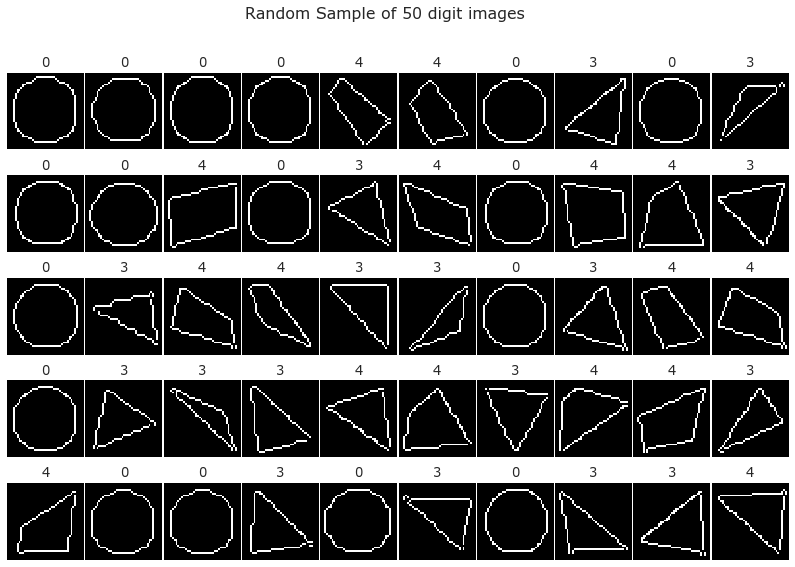

In [100]:
# display 50 random samples
sample_size = 50
print('Displaying a random sample of {} images from dataset'.format(sample_size))
indexes = np.random.randint(0, test_images.shape[0], sample_size)
sample_images, sample_labels = test_images[indexes], test_labels[indexes]
display_sample(sample_images, sample_labels, sample_predictions=None, num_rows=5, num_cols=10, 
               plot_title="Random Sample of {} digit images".format(sample_size))

# Keras Implementation
We will develop model using Keras' Sequential API, which is much simpler to understand that the Functional API.

In [101]:
#replaced keras with tensorflow.compat.v2.keras.
# import tensorflow.compat.v2.keras.backend as K
# from tensorflow.compat.v2.keras.models import Sequential
# from tensorflow.compat.v2.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
# from tensorflow.compat.v2.keras import optimizers
# import kr_helper_funcs as kru

import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras import optimizers
import kr_helper_funcs as kru

# clear the Tensorflow backend to get rid of any spurious graphs
#K.clear_session()

In [102]:
def build_keras_model():
    K.clear_session()
    
    model = Sequential()
    model.add(Conv2D(64, kernel_size=KERNEL_SIZE, padding='same', activation='relu',
                    input_shape=IMAGE_SHAPE))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(64, kernel_size=KERNEL_SIZE, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Flatten())
    model.add(Dropout(0.45))
    # output is softmax for 10 classes
    model.add(Dense(num_classes, activation='softmax'))
    adam = optimizers.Adam(lr=alpha)
    model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['acc'])
    
    return model

In [103]:
kr_model = build_keras_model()
print(kr_model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 40, 40, 64)        5248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 20, 20, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 20, 20, 64)        331840    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 6400)              0         
_________________________________________________________________
dropout (Dropout)            (None, 6400)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 1

In [104]:
# train the model
%time history = kr_model.fit(X_train, y_train, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE,validation_data=(X_val, y_val))

Train on 48000 samples, validate on 9600 samples
Epoch 1/15
48000/48000 [==============================] - 6s 125us/sample - loss: 0.3208 - acc: 0.8514 - val_loss: 0.2027 - val_acc: 0.9214
Epoch 2/15
48000/48000 [==============================] - 5s 112us/sample - loss: 0.1811 - acc: 0.9258 - val_loss: 0.1380 - val_acc: 0.9521
Epoch 3/15
48000/48000 [==============================] - 5s 113us/sample - loss: 0.1432 - acc: 0.9455 - val_loss: 0.1175 - val_acc: 0.9596
Epoch 4/15
48000/48000 [==============================] - 5s 114us/sample - loss: 0.1289 - acc: 0.9516 - val_loss: 0.1111 - val_acc: 0.9620
Epoch 5/15
48000/48000 [==============================] - 6s 115us/sample - loss: 0.1192 - acc: 0.9556 - val_loss: 0.1099 - val_acc: 0.9630
Epoch 6/15
48000/48000 [==============================] - 5s 112us/sample - loss: 0.1114 - acc: 0.9597 - val_loss: 0.1014 - val_acc: 0.9647
Epoch 7/15
48000/48000 [==============================] - 5s 113us/sample - loss: 0.1066 - acc: 0.9609 - val_lo

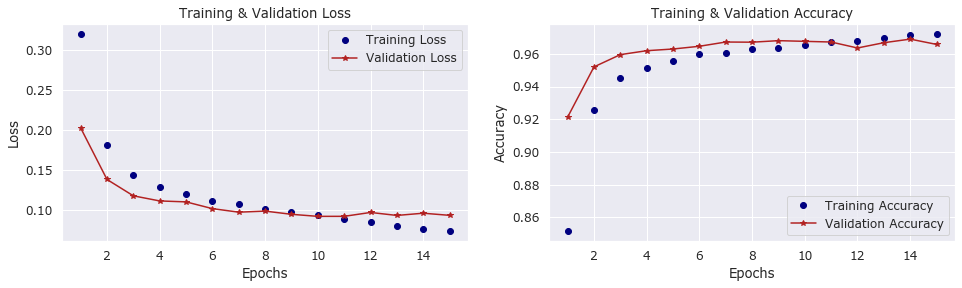

In [105]:
# display plots of loss & accuracies
kru.show_plots(history.history)

In [86]:
# evaluate performance against train/cross-val & test data
print('Evaluating performance of Keras model:')
loss, acc = kr_model.evaluate(X_train, y_train, batch_size=BATCH_SIZE, verbose=0)
print(' - Training dataset: loss = {:.4f}, accuracy = {:.4f}'.format(loss, acc))

loss, acc = kr_model.evaluate(X_val, y_val, batch_size=BATCH_SIZE, verbose=0)
print(' - Cross-validation dataset: loss = {:.4f}, accuracy = {:.4f}'.format(loss, acc))

loss, acc = kr_model.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=0)
print(' - Test dataset: loss = {:.4f}, accuracy = {:.4f}'.format(loss, acc))

Evaluating performance of Keras model:
 - Training dataset: loss = 0.0643, accuracy = 0.9766
 - Cross-validation dataset: loss = 0.1021, accuracy = 0.9583
 - Test dataset: loss = 0.1121, accuracy = 0.9563


# Saving Model

In [33]:
# save model and architecture to single file
kr_model.save(KR_MODEL_NAME)
print("Saved model to disk")

Saved model to disk


In [106]:
predictions = kr_model.predict(X_test)
# reverse one-hot encode the predictions
y_pred = np.argmax(predictions, axis=1)
# reverse one-hot encode of test data (this is the ground truth)
y_true = np.argmax(y_test, axis=1)
#y_pred[:30]
# count of predictions & how many incorrect predictions overall??
len(y_pred), (y_pred != y_true).sum()

(2400, 83)

Displaying a sample of 50 mistaken images from dataset


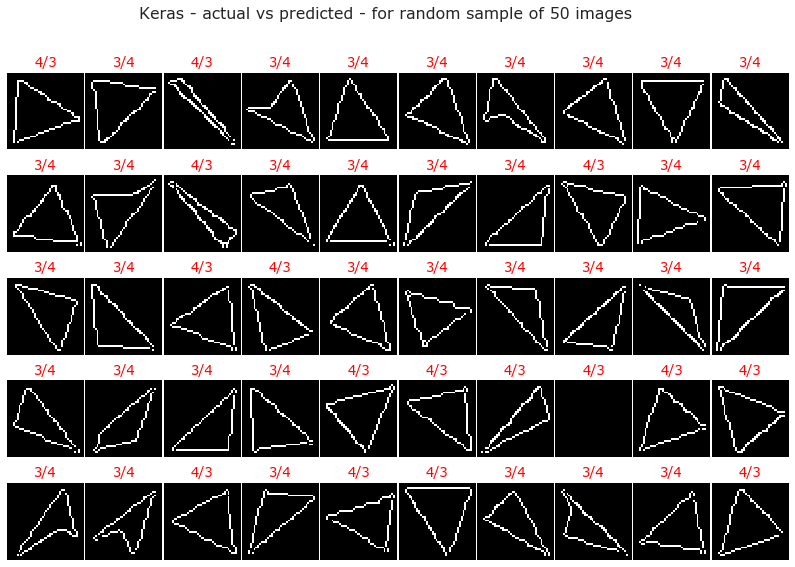

In [107]:
# NOTE: the title of each cell shows the predicted value in green if prediction matches actual
# else cell title shows actual/predicted value in red font
sample_size = 50
print('Displaying a sample of {} mistaken images from dataset'.format(sample_size))
indexes = np.where(y_pred != y_true)[0].astype('int32')[:sample_size]
sample_images, sample_labels, sample_predictions = test_images[indexes], test_labels[indexes], y_pred[indexes]
display_sample(sample_images, sample_labels, sample_predictions=sample_predictions, 
               num_rows=5, num_cols=10, 
               plot_title="Keras - actual vs predicted - for random sample of {} images".format(sample_size))

In [16]:
import gc
gc.collect()

81051